In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc
from typing import Tuple, Optional, Dict
from functools import partial

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage
import wandb

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

from research.data.natural_scenes import (
    NaturalScenesDataset,
    StimulusDataset,
    KeyDataset
)
from research.models.components_2d import BlurConvTranspose2d
from research.models.fmri_decoders import VariationalDecoder, SpatialDecoder, SpatialDiscriminator, Decoder
from research.models.fmri_encoders import Encoder, SpatialEncoder
from research.metrics.loss_functions import (
    EuclideanLoss,
    EmbeddingClassifierLoss,
    ProbabalisticCrossEntropyLoss,
    VariationalLoss,
    CosineSimilarityLoss,
    EmbeddingDistributionLoss,
    ContrastiveDistanceLoss,
)
from research.experiments.nsd.nsd_experiment import NSDExperiment
from research.metrics.metrics import (
    cosine_similarity, 
    r2_score,
    pearsonr,
    embedding_distance,
    cosine_distance,
    squared_euclidean_distance,
    contrastive_score,
    two_versus_two,
    smooth_euclidean_distance,
    top_knn_test
)
from pipeline.utils import product, index_unsorted

In [2]:
from research.models.fmri_decoders import VariationalDecoder, SpatialDecoder, SpatialDiscriminator, Decoder
from torch.optim.lr_scheduler import StepLR

nsd_path = Path('D:\\Datasets\\NSD\\')
nsd = NaturalScenesDataset(nsd_path)

In [ ]:
model_params = dict(
    layer_sizes=[
        512,
        5000,
        512,
    ],
    dropout_p=0.,
)
model = Decoder(**model_params)

optimizer_params = dict(lr=1e-4)
optimizer = Adam(
    params=model.parameters(),
    **optimizer_params,
)

scheduler_params = dict(
    step_size=500,
    gamma=0.5,
)
scheduler = StepLR(optimizer, **scheduler_params)

In [3]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

In [8]:
from research.experiments.nsd.nsd_run_decoding import main

model_name = 'ViT-B=32'
stimulus_key = 'embedding'
#model_name = 'clip-vit-large-patch14'
#stimulus_key = 'image_embedding'
voxel_selection = 'nc'
threshold = 5.
num_voxels = None

if voxel_selection == 'nc':
    voxel_selection_path = 'derivatives/noise-ceiling.hdf5'
    if threshold is None:
        voxel_selection_key = f'split-01/sorted_indices'
    else:
        voxel_selection_key = f'split-01/value'
elif voxel_selection == 'fracridge':
    voxel_selection_path = f'derivatives/encoded_betas/{model_name}/fracridge.hdf5'
    if threshold is None:
        voxel_selection_key = f'{stimulus_key}/volume_indices'
    else:
        voxel_selection_key = f'{stimulus_key}/value'
        
grid_params = [
    ('group-12', 'distance'), ('group-13', 'contrastive'), ('group-14', 'balanced'),
]

#for group_name, loss in grid_params:
    #for subject_id in range(8):
#subject_name = f'subj0{subject_id+1}'

for permutation_fraction in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    subject_name = f'subj01'
    experiment = main(
        nsd_path,
        subject_name,
        model_name,
        stimulus_key,
        voxel_selection_path=voxel_selection_path,
        voxel_selection_key=voxel_selection_key,
        group='fractional_permutation',
        permutation_test=True,
        permutation_fraction=permutation_fraction,
        max_iterations=1501,
        loss='contrastive',
        #loss=loss,
        batch_size=128,
        num_voxels=None,
        threshold=threshold,
        #result_key='wandb_run_name',
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: efirdc. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [06:20<00:00,  3.94it/s]


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
loss,█▇▇▆▆▅▅▅▅▃▃▃▄▄▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [06:17<00:00,  3.98it/s]


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
loss,█▇▇▆▆▆▅▅▆▄▄▄▄▄▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [06:14<00:00,  4.00it/s]


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
loss,██▇▇▇▆▆▆▆▅▄▄▅▅▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [06:15<00:00,  3.99it/s]


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
loss,█▇▇▇▇▆▆▆▆▅▄▅▅▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [06:13<00:00,  4.02it/s]


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
loss,█████▇▇▇▇▅▅▅▅▅▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [06:08<00:00,  4.07it/s]


batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
loss,█████▇▇▇█▅▅▅▅▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
loss = nn.MSELoss(reduction='none')
prediction = torch.randn(30, 512)
prediction = prediction / torch.linalg.norm(prediction, axis=1, keepdim=True)
target = torch.randn(30, 512)
target = target / torch.linalg.norm(target, axis=1, keepdim=True)
output = loss(prediction, target)
output

In [ ]:
with torch.no_grad():
    Y, Y_pred, stimulus_ids = experiment.run_all(experiment.val_dataset)

In [ ]:
r2 = r2_score(Y, Y_pred, reduction=None)
r2_argsort_ids = np.argsort(r2)

for dim, dim_r2 in zip(r2_argsort_ids[:10], r2[r2_argsort_ids[:10]]):
    print(f'{round(dim.item(), 3)}, {round(dim_r2.item(), 3)}')

r2[r2 < -0.1] = 0
plt.hist(r2)
#ax[i].set_ylim(0, 225)
#ax[i].set_xlim(-0.1, 0.7) 
#ax[i].set_xticks([0.0, 0.2, 0.4, 0.6])
#if i > 0:
    #ax[i].set_yticks([])
#ax[i].set_xlabel(subject)
plt.show()
                       

In [6]:
# Load data

from research.models.fmri_decoders import Decoder

subject_name = 'subj01'
model_name = 'ViT-B=32'
stimulus_key = 'embedding'
voxel_selection = 'nc'
threshold = 5.
num_voxels = None

if voxel_selection == 'nc':
    voxel_selection_path = 'derivatives/noise-ceiling.hdf5'
    if threshold is None:
        voxel_selection_key = f'split-01/sorted_indices'
    else:
        voxel_selection_key = f'split-01/value'
elif voxel_selection == 'fracridge':
    voxel_selection_path = f'derivatives/encoded_betas/{model_name}/fracridge.hdf5'
    if threshold is None:
        voxel_selection_key = f'{stimulus_key}/volume_indices'
    else:
        voxel_selection_key = f'{stimulus_key}/value'

        
train_mask, val_mask, test_mask = nsd.get_split(subject_name, 'split-01')

betas_params = dict(
    subject_name=subject_name,
    voxel_selection_path=voxel_selection_path,
    voxel_selection_key=voxel_selection_key,
    num_voxels=num_voxels,
    threshold=threshold,
    return_volume_indices=True,
    return_tensor_dataset=False,
)
betas, betas_indices = nsd.load_betas(**betas_params)
X_train, X_val, X_test = betas[train_mask], betas[val_mask], betas[test_mask]

stimulus_params = dict(
    subject_name=subject_name,
    stimulus_path=f'derivatives/stimulus_embeddings/{model_name}.hdf5',
    stimulus_key=stimulus_key,
    delay_loading=False,
    return_tensor_dataset=False,
    return_stimulus_ids=True,
)
stimulus, stimulus_ids = nsd.load_stimulus(**stimulus_params)
stimulus = stimulus.astype(np.float32)
Y_train, Y_val, Y_test = stimulus[train_mask], stimulus[val_mask], stimulus[test_mask]

In [ ]:
n = 3
unique_ids, unique_counts = np.unique(stimulus_ids[train_mask], return_counts=True)
atleast_n_ids = unique_ids[unique_counts >= n]
repetition_ids = np.stack([
    np.where(stimulus_ids[train_mask] == i)[0][:n]
    for i in atleast_n_ids
])

In [ ]:
for i in unique_ids:
    stimulus_betas = X_train[stimulus_ids[train_mask] == i]
    betas_var.append(stimulus_betas.var(axis=0, ddof=1))
betas_var_mean = np.nanmean(np.stack(betas_var), axis=0)

std_noise = np.sqrt(betas_var_mean)

In [30]:
alpha_results

{0.1: [0.012333333333333333, 0.051, 0.089, 0.274, 0.4036666666666667, 0.846],
 1.0: [0.015666666666666666,
  0.05633333333333333,
  0.099,
  0.296,
  0.43666666666666665,
  0.8636666666666667],
 10.0: [0.018333333333333333,
  0.06266666666666666,
  0.106,
  0.317,
  0.459,
  0.8763333333333333],
 100.0: [0.030666666666666665,
  0.1,
  0.162,
  0.4146666666666667,
  0.5526666666666666,
  0.9116666666666666],
 1000: [0.06566666666666666,
  0.19166666666666668,
  0.2806666666666667,
  0.5826666666666667,
  0.715,
  0.953],
 10000: [0.08533333333333333,
  0.23233333333333334,
  0.3373333333333333,
  0.6496666666666666,
  0.768,
  0.9606666666666667],
 100000.0: [0.052,
  0.15666666666666668,
  0.23666666666666666,
  0.545,
  0.683,
  0.9353333333333333],
 1000000.0: [0.018,
  0.064,
  0.10833333333333334,
  0.33366666666666667,
  0.48,
  0.8543333333333333],
 5000.0: [0.079,
  0.23066666666666666,
  0.3413333333333333,
  0.6416666666666667,
  0.7693333333333333,
  0.96],
 50000.0: [0.066, 

WindowsPath('D:/Datasets/NSD')

In [45]:
from sklearn.linear_model import RidgeCV, Ridge
from research.models.fmri_decoders import Decoder

model_name = 'ViT-B=32'
stimulus_key = 'embedding'
    
with h5py.File(nsd_path / f'derivatives/decoded_features/{model_name}/ridge-1.hdf5', 'a') as f:
    #results = {}
    for subject_id in range(1, 8):
        gc.collect()
        subject_name = f'subj0{subject_id+1}'
        print(subject_name)
        voxel_selection = 'nc'
        threshold = 5.
        num_voxels = None

        if voxel_selection == 'nc':
            voxel_selection_path = 'derivatives/noise-ceiling.hdf5'
            if threshold is None:
                voxel_selection_key = f'split-01/sorted_indices'
            else:
                voxel_selection_key = f'split-01/value'
        elif voxel_selection == 'fracridge':
            voxel_selection_path = f'derivatives/encoded_betas/{model_name}/fracridge.hdf5'
            if threshold is None:
                voxel_selection_key = f'{stimulus_key}/volume_indices'
            else:
                voxel_selection_key = f'{stimulus_key}/value'

        train_mask, val_mask, test_mask = nsd.get_split(subject_name, 'split-01')

        betas_params = dict(
            subject_name=subject_name,
            voxel_selection_path=voxel_selection_path,
            voxel_selection_key=voxel_selection_key,
            num_voxels=num_voxels,
            threshold=threshold,
            return_volume_indices=True,
            return_tensor_dataset=False,
        )
        betas, betas_indices = nsd.load_betas(**betas_params)
        X_train, X_val, X_test = betas[train_mask], betas[val_mask], betas[test_mask]

        stimulus_params = dict(
            subject_name=subject_name,
            stimulus_path=f'derivatives/stimulus_embeddings/{model_name}.hdf5',
            stimulus_key=stimulus_key,
            delay_loading=False,
            return_tensor_dataset=False,
            return_stimulus_ids=True,
        )
        stimulus, stimulus_ids = nsd.load_stimulus(**stimulus_params)
        stimulus = stimulus.astype(np.float32)
        Y_train, Y_val, Y_test = stimulus[train_mask], stimulus[val_mask], stimulus[test_mask]

        best_model = None
        best_top_1 = 0

        alpha_grid = (0.1, 1, 10, 100, 1000, 10000, 100000)
        alpha_results = results[subject_name] = []
        for alpha in alpha_grid:
            gc.collect()
            model = Ridge(alpha=alpha)
            model.fit(X_train, Y_train)
            Y_val_pred = model.predict(X_val)

            metric = 'cosine'
            top_k_values = [1]

            unique_stimulus_ids, unique_index, unique_inverse = np.unique(stimulus_ids[val_mask], return_index=True, return_inverse=True)
            top_knn_accuracy = top_knn_test(Y_val[unique_index], Y_val_pred, unique_inverse, k=top_k_values, metric=metric)
            print(alpha, top_knn_accuracy)
            alpha_results.append(top_knn_accuracy[0])

            if top_knn_accuracy[0] > best_top_1:
                best_top_1 = top_knn_accuracy[0]
                best_model = model
                
        Y_val_pred = best_model.predict(X_val)
        Y_test_pred = best_model.predict(X_test)
        
        group = f.create_group(f'{subject_name}/{stimulus_key}')
        group[f'model/weight'] = model.coef_
        group[f'model/bias'] = model.intercept_
        group[f'volume_indices'] = betas_indices
        group[f'val/Y_pred'] = Y_val_pred
        group[f'val/stimulus_ids'] = stimulus_ids[val_mask]
        group[f'test/Y_pred'] = Y_test_pred
        group[f'test/stimulus_ids'] = stimulus_ids[test_mask]
    

subj02


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.0114e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


0.1 [0.02033333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.84729e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


1 [0.021333333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.75259e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


10 [0.022]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.43707e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


100 [0.028333333333333332]
1000 [0.060333333333333336]
10000 [0.06433333333333334]
100000 [0.033]
subj03


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.93445e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


0.1 [0.012]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.03736e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


1 [0.012333333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.2663e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


10 [0.013]
100 [0.019666666666666666]
1000 [0.043]
10000 [0.043]
100000 [0.027]
subj04


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.4422e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


0.1 [0.025333333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.45902e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


1 [0.025333333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.03817e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


10 [0.025666666666666667]
100 [0.032]
1000 [0.042]
10000 [0.04666666666666667]
100000 [0.020666666666666667]
subj05


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.90666e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


0.1 [0.014]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.73863e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


1 [0.013666666666666667]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.6922e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


10 [0.018333333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.33993e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


100 [0.03766666666666667]
1000 [0.08166666666666667]
10000 [0.101]
100000 [0.059]
subj06


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


0.1 [0.036333333333333336]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.58191e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


1 [0.036]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.59047e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


10 [0.03666666666666667]
100 [0.04033333333333333]
1000 [0.047]
10000 [0.055]
100000 [0.035666666666666666]
subj07


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.24108e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


0.1 [0.025]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.28115e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


1 [0.025]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.67622e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


10 [0.027]
100 [0.034333333333333334]
1000 [0.051333333333333335]
10000 [0.06166666666666667]
100000 [0.027333333333333334]
subj08


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.90975e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


0.1 [0.0033333333333333335]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25969e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


1 [0.0033333333333333335]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.19385e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


10 [0.007333333333333333]


C:\Users\Cefir\anaconda3\envs\neuro-decode\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.49617e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


100 [0.015666666666666666]
1000 [0.023333333333333334]
10000 [0.030333333333333334]
100000 [0.015666666666666666]


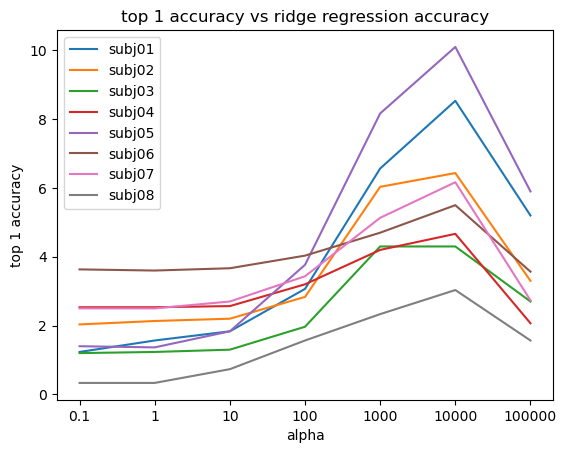

In [57]:
x = np.arange(len(alpha_grid))
plt.xlabel('alpha')
plt.ylabel('top 1 accuracy')
plt.title('top 1 accuracy vs ridge regression accuracy')
for subject_name, top_1 in results.items():
    plt.plot(x, np.array(top_1) * 100, label=subject_name)
    plt.xticks(x, alpha_grid)
plt.legend()
plt.show()

In [44]:
with h5py.File(nsd_path / f'derivatives/decoded_features/{model_name}/ridge-1.hdf5', 'w') as f:
    group = f.create_group(f'{subject_name}/{stimulus_key}')
    group[f'model/weight'] = model.coef_
    group[f'model/bias'] = model.intercept_
    group[f'volume_indices'] = betas_indices
    group[f'val/Y_pred'] = Y_val_pred
    group[f'val/stimulus_ids'] = stimulus_ids[val_mask]
    group[f'test/Y_pred'] = Y_test_pred
    group[f'test/stimulus_ids'] = stimulus_ids[test_mask]

In [39]:
model.intercept_

array([-7.17748841e-03,  1.56651419e-02, -2.49491050e-03,  2.26902775e-02,
        1.02065457e-02,  8.46225186e-04,  1.49679817e-02, -4.93894564e-03,
        3.84459551e-03,  8.01596045e-03,  9.43797082e-03, -1.43056512e-02,
        1.68215223e-02, -2.00840575e-03,  5.69361355e-03, -1.35061070e-02,
        2.72260909e-03,  1.39706684e-02,  1.09957205e-03, -1.53705720e-02,
       -2.33174507e-02,  5.02627762e-03,  4.95025050e-03, -1.55067509e-02,
       -8.75763595e-03,  1.24081606e-02, -4.34409856e-04, -3.29955015e-03,
       -6.60810713e-03, -9.25513357e-03, -8.09021294e-03,  1.40768038e-02,
       -3.87934293e-03,  1.83499302e-03,  9.67128947e-03,  9.39584896e-03,
       -3.28714214e-03,  4.37201263e-04, -3.88082792e-03,  7.05893561e-02,
       -4.59140074e-03, -2.12216240e-04, -5.10125002e-03, -1.43643012e-02,
        7.53212906e-03, -7.46068507e-02,  2.13981457e-02,  1.47317713e-02,
       -1.11071803e-02,  8.44378583e-03,  4.42298735e-03,  2.26989179e-03,
        1.19916769e-02, -

In [22]:
gc.collect()

3823

In [11]:
metric = 'cosine'
top_k_values = [1, 5, 10, 50, 100, 500]

unique_stimulus_ids, unique_index, unique_inverse = np.unique(stimulus_ids[val_mask], return_index=True, return_inverse=True)
top_knn_accuracy = top_knn_test(Y_val[unique_index], Y_val_pred, unique_inverse, k=top_k_values, metric=metric)

In [12]:
top_knn_accuracy

[0.015666666666666666,
 0.05633333333333333,
 0.099,
 0.296,
 0.43666666666666665,
 0.8636666666666667]

In [ ]:
wandb_logging = False,

run_models = [
    ('ViT-B=32', 'embedding'),
    #('ViT-B=32', 'transformer.resblocks.3'),
    #('bigbigan-resnet50', 'z_mean'),
    #('DPT_Large', 'scratch.refinenet4'),
]

run_models += [('ViT-B=32', f'transformer.resblocks.{i}') for i in range(12)]

#subjects = nsd.subjects.keys()
#subjects = [f'subj0{i}' for i in range(1, 9)]
#subjects = [f'subj06' for i in range(1, 9)]

for model_name, stimulus_key in run_models:
    for subject_name in subjects:
        def run():
            notes = None

            experiment_params = dict(
                batch_size=128 if stimulus_key == 'embedding' else 64,
                distance_metric='cosine' if stimulus_key == 'embedding' else 'euclidean',
                group='group-4',
                max_iterations = 10001,
                evaluation_interval = 2500,
                channels_last=False, # (model_name == 'ViT-B=32' and stimulus_key != 'embedding'),
                wandb_logging=True,
            )

            betas_params = dict(
                subject_name=subject_name,
                voxel_selection_path='derivatives/voxel-selection.hdf5',
                voxel_selection_key='nc/sorted_indices_flat',
                num_voxels=2500,
                return_volume_indices=True
            )
            betas, betas_indices = nsd.load_betas(**betas_params)

            stimulus_params = dict(
                subject_name=subject_name,
                #stimulus_path='nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5',
                #stimulus_key='imgBrick',
                stimulus_path=f'derivatives/stimulus_embeddings/{model_name}.hdf5',
                stimulus_key=stimulus_key,
                delay_loading=True
            )
            stimulus = nsd.load_stimulus(**stimulus_params)

            dataset = KeyDataset({'betas': betas, 'stimulus': stimulus})
            train_dataset, val_dataset, test_dataset = nsd.apply_subject_split(dataset, subject_name, 'split-01')

            config = {'model_name': model_name, **betas_params, **stimulus_params}
            experiment = run_experiment(
                train_dataset,
                val_dataset,
                config=config,
                **experiment_params,
            )


            with torch.no_grad():
                _, Y_val_pred, Y_val_ids = experiment.run_all(val_dataset)
                _, Y_test_pred, Y_test_ids = experiment.run_all(test_dataset)
                _ = None


            def require_dataset(group, key, tensor):
                if key in group:
                    group[key][:] = tensor
                else:
                    group[key] = tensor
            results_path = nsd_path / 'derivatives/decoded_features'

            key_name = wandb.run.group if wandb.run.group else wandb.run.name
            save_file_path = results_path / wandb.config['model_name'] / f'{key_name}.hdf5'
            save_file_path.parent.mkdir(exist_ok=True, parents=True)

            h5_key = (wandb.config['subject_name'], wandb.config['stimulus_key'])

            attributes = dict(wandb.config)
            attributes['wandb_run_name'] = wandb.run.name
            attributes['wandb_run_url'] = wandb.run.url
            attributes['wandb_group'] = wandb.run.group
            attributes['wandb_notes'] = wandb.run.notes

            with h5py.File(save_file_path, 'a') as f:
                key = '/'.join(h5_key)
                group = f.require_group(key)
                for k, v in attributes.items():
                    group.attrs[k] = v
                group.attrs['iteration'] = experiment.iteration
                require_dataset(group, 'volume_indices', betas_indices)
                require_dataset(group, 'test/Y_pred', Y_test_pred.detach().cpu())
                require_dataset(group, 'test/stimulus_ids', Y_test_ids)
                require_dataset(group, 'val/Y_pred', Y_val_pred.detach().cpu())
                require_dataset(group, 'val/stimulus_ids', Y_val_ids)

                model_group = group.require_group('model')
                for param_name, weights in experiment.model.state_dict().items():
                    weights = weights.cpu()
                    require_dataset(model_group, param_name, weights)

            experiment = None
            wandb.finish()
        run()
        torch.cuda.empty_cache()
        gc.collect()


In [ ]:
results_path = nsd_path / 'derivatives/decoded_features'

group_name = 'group-5'
fold = 'val'

eval_models = [
    ('group-10', 'ViT-B=32', 'embedding'),
    #('group-3', 'bigbigan-resnet50', 'z_mean'),
    #('DPT_Large', 'scratch.refinenet4'),
    #('group-5', 'clip-vit-large-patch14-text', 'embedding_unpooled')
]
#eval_models += [('ViT-B=32', f'transformer.resblocks.{i}') for i in range(12)]

subjects = [f'subj0{i}' for i in range(1, 9)]
top_k_values = [1, 5, 10, 50, 100, 500]

results = {}
for group_name, model_name, stimulus_key in eval_models:
    results[(model_name, stimulus_key)] = stimulus_results = {}
    
    stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{model_name}.hdf5', 'r')
    stimulus = stimulus_file[stimulus_key]
    result_file = h5py.File(nsd_path / f'derivatives/decoded_features/{model_name}/{group_name}.hdf5', 'r')
    
    for subject_name in subjects:
        stimulus_results[subject_name] = subject_results = {}
        print(model_name, stimulus_key, subject_name)
        result = result_file[subject_name][stimulus_key][fold]
        stimulus_ids = result['stimulus_ids'][:]
        
        print('load')
        Y_pred = result['Y_pred'][:]
        Y = index_unsorted(stimulus, stimulus_ids)
        N = Y.shape[0]
        Y_pred = Y_pred.reshape(N, -1)
        Y = Y.reshape(N, -1)
        
        print('knn')
        metric = 'cosine' if stimulus_key == 'embedding' else 'euclidean' 
        
        unique_stimulus_ids, unique_index, unique_inverse = np.unique(stimulus_ids, return_index=True, return_inverse=True)
        top_knn_accuracy = top_knn_test(Y[unique_index], Y_pred, unique_inverse, k=top_k_values, metric=metric)
        subject_results['top_knn_accuracy'] = top_knn_accuracy
        print(subject_results)
        

In [ ]:
N = 1000
chance_accuracy = [k / N for k in top_k_values]

model_name = 'ViT-B=32'
stimulus_key = 'embedding'

plt.figure(figsize=(12, 8))
plt.xticks(ticks=range(len(top_k_values)), labels=top_k_values)
plt.title(f'Top knn accuracy (n={N})\n{model_name=}, {stimulus_key=}')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(range(len(top_k_values)), chance_accuracy, label='chance (k/n)', color='gray')
for subject, subject_results in results[(model_name, stimulus_key)].items():
    top_knn_accuracy = subject_results['top_knn_accuracy']
    plt.plot(range(len(top_k_values)), top_knn_accuracy, label=subject)

plt.grid()
plt.legend()
plt.show()

In [ ]:
N = 1000
chance_accuracy = [k / N for k in top_k_values]

model_name = 'clip-vit-large-patch14-text'
stimulus_key = 'embedding_unpooled'

plt.figure(figsize=(12, 8))
plt.xticks(ticks=range(len(top_k_values)), labels=top_k_values)
plt.title(f'Top knn accuracy (n={N})\n{model_name=}, {stimulus_key=}')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(range(len(top_k_values)), chance_accuracy, label='chance (k/n)', color='gray')
for subject, subject_results in results[(model_name, stimulus_key)].items():
    top_knn_accuracy = subject_results['top_knn_accuracy']
    plt.plot(range(len(top_k_values)), top_knn_accuracy, label=subject)

plt.legend()
plt.show()

In [ ]:
unique_stimulus_ids, unique_indices = np.unique(stimulus_ids, return_index=True)

np.stack([Y_pred[i == stimulus_ids].mean(axis=0) for i in unique_stimulus_ids]).shape

In [ ]:
Y_pred.shape